In [3]:
import pandas as pd
import numpy as np
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.metrics import  precision_score,recall_score,f1_score
from collections import Counter
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix    
from sklearn.model_selection import KFold
from sklearn import metrics
from sklearn import tree
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
import warnings
import matplotlib.pyplot as plt
from functools import reduce
from tqdm import tqdm

In [4]:
train_path = pd.read_csv("messages_train.csv")
test_path = pd.read_csv("messages_test.csv")

In [5]:
def EstablishDictionary(train):
    #print(train)
    message = train['message'] #获取名字为message列的数据
    print(message)
    message_list = message.values.tolist()#将csv文件中message列中的数据保存到列表中
    all_words = []
    for mes in message_list:
        words=mes.split()
        all_words+=words
    dictionary = Counter(all_words)  
    dictionary2 = dictionary.keys()
    for word in list(dictionary2):#设置去除常见的字
        if word.isalpha() == False: del dictionary[word]
        elif len(word) == 1:    del dictionary[word]   
        elif len(word) == 2:    del dictionary[word]   
        elif len(word) >= 16:    del dictionary[word]  # 16可改为18,20等
    dictionary = dictionary.most_common(1000)   
    return dictionary
dictionary = EstablishDictionary(train_path)
# print(dictionary)


def EstablishDictionary_iter(train,a):
    message  = train['message'] #获取名字为message列的数据
    message_list = message.values.tolist()#将csv文件中message列中的数据保存到列表中
    all_words = []
    for mes in message_list:
        words=mes.split()
        all_words+=words
    dictionary = Counter(all_words)  
    dictionary2 = dictionary.keys()
    for word in list(dictionary2):#设置去除常见的字
        if word.isalpha() == False: del dictionary[word]
        elif len(word) == 1:    del dictionary[word]   
        elif len(word) == 2:    del dictionary[word] 
        elif len(word) >= 16:    del dictionary[word]  # 16可改为18,20等
    dictionary = dictionary.most_common(a)   
    return dictionary
dictionary_iter=[]
# dictionary_iter.append(EstablishDictionary_iter(train_path, ii) for ii in range(1000,2050,100)) 
# print(dictionary_iter)
dictionary_iter=list(EstablishDictionary_iter(train_path, ii) for ii in range(1000,2050,50))


def analyse_characters(df):  # 特征分析(不可循环版)(括号内删除,df为pandas导入的messages.csv)
    chars_matrix = np.zeros((len(df),1000))  # 特征矩阵 初始化为0,len(df)为行 代表邮件封数,1000代表词典关键词大小
    ccc = 0;  # 每读取一封邮件便+1
    for x in df['message']:  # x = 邮件内容
        words = x.split()  # 分割内容中的每个单词合并成一个列表
        for word in words:  # 对列表中每个单词
            for index,d in enumerate(dictionary):  # 词典(linenum为序号,d为 (单词,单词次数) )
                if d[0] == word:  # 若这个单词与词典中的词相同
                    chars_matrix[ccc,index] = words.count(word)  # 调用count方法统计word的个数并赋值给特征矩阵对应位置
        ccc += 1  # 每读取一封邮件便+1
    return chars_matrix  # 返回特征矩阵


def analyse_characters_iter(df, ai, b):  # 特征分析(可循环版)(括号内删除,df为pandas导入的messages.csv, b为迭代词典序号1000,1050记为0,1等)
    chars_matrix = np.zeros((len(df), ai))  # 特征矩阵 初始化为0,len(df)为行 代表邮件封数,参数ai代表词典关键词大小
    ccc = 0;  # 每读取一封邮件便+1
    for x in df['message']:  # x = 邮件内容
        words = x.split()  # 分割内容中的每个单词合并成一个列表
        for word in words:  # 对列表中每个单词
            for index,d in enumerate(dictionary_iter[b]):  # 词典(index为序号,d为 (单词,单词次数) )            555
                if d[0] == word:  # 若这个单词与词典中的词相同
                    chars_matrix[ccc,index] = words.count(word)  # 调用count方法统计word的个数并赋值给特征矩阵对应位置
        ccc += 1  # 每读取一封邮件便+1
    return chars_matrix  # 返回特征矩阵
# 为每一封邮件和标签准备特征向量

AVEF1=[] # 不同ai的平均值，从这里找最大值
F1STATUS=[] # 不同ai的状态。用于输出
for a in tqdm(range(1000,2050,100)): # 遍历
    b=(a-1000)//50
    y_train = np.zeros(800)
    y_train[640:800] = 1
    y_test=np.zeros(200)
    y_test[160:200] = 1 
    X_train = analyse_characters_iter(train_path,a,b)
    # Test the unseen mails for Spam               
    X_test = analyse_characters_iter(test_path,a,b)
    aveF1Data = []
    maxF1Data = []
    status=[]
    def modeAverageF1(factAI,start,stop,step):
        f1Data = []
        for factor in np.arange(start,stop,step):
            mode = factAI(factor)
            mode.fit(X_train,y_train)
            result = mode.predict(X_test)
            f1Data.append(f1_score(y_test,result, average='weighted'))
        return sum(f1Data)/len(f1Data)
    def modeMaxF1(factAI,start,stop,step):
        f1Data = []
        for factor in np.arange(start,stop,step):
            mode = factAI(factor)
            mode.fit(X_train,y_train)
            result = mode.predict(X_test)
            f1Data.append(f1_score(y_test,result, average='weighted'))
        return max(f1Data),f1Data.index(max(f1Data))*step+start
    def modeAverageF1Random(factAI,start,stop,step):
        f1Data = []
        for factor in np.arange(start,stop,step):
            for count in range(3):
                mode = factAI(factor)
                mode.fit(X_train,y_train)
                result = mode.predict(X_test)
                f1Data.append(f1_score(y_test,result , average='weighted'))
        return sum(f1Data)/len(f1Data)
    def modeMaxF1Random(factAI,start,stop,step):
        f1Data = []
        for factor in np.arange(start,stop,step):
            for count in range(3):
                mode = factAI(factor)
                mode.fit(X_train,y_train)
                result = mode.predict(X_test)
                f1Data.append(f1_score(y_test,result , average='weighted'))
        return max(f1Data),f1Data.index(max(f1Data))*step+start


    print("————————以下是朴素贝叶斯模型的拟合结果————————")
    model1 = MultinomialNB(alpha=1.0e-10) #多项式朴素贝叶斯模型,且对拉普拉斯平滑系数进行了调参
    model1.fit(X_train,y_train)
    result1 = model1.predict(X_test)
    aveF1Data.append(f1_score(y_test,result1 , average='weighted'))

    print("————————以下是决策树模型的拟合结果————————")
    model2= tree.DecisionTreeClassifier(criterion='entropy',random_state=0)
    model2.fit(X_train,y_train)
    result2 = model2.predict(X_test)
    aveF1Data.append(f1_score(y_test,result2 , average='weighted'))

    print("————————以下是KNN模型的拟合结果————————")
    factKNN=lambda fact : KNeighborsClassifier(n_neighbors=fact,weights='uniform',p=2)#n_neighbors从1到30,步长为1
    model3=KNeighborsClassifier(n_neighbors=30,weights='uniform',p=2)
    model3.fit(X_train,y_train)
    result3=model3.predict(X_test)
    aveF1Data.append(modeAverageF1(factKNN,1,30,1))
    status.append(modeMaxF1(factKNN,1,30,1))
    maxF1Data.append(status[-1][0])

    print("————————以下是SVC模型的拟合结果————————")
    factSVC=lambda fact : SVC(kernel='linear',random_state=1,C=fact)# C从0.1到1,步长为0.1
    model4=SVC(kernel='linear',random_state=1,C=1)# C从0.1到1,步长为0.1
    model4.fit(X_train,y_train)
    result4 = model4.predict(X_test)
    aveF1Data.append(modeAverageF1(factSVC,0.1,1,0.1))
    status.append(modeMaxF1(factSVC,0.1,1,0.1))
    maxF1Data.append(status[-1][0])

    print("————————以下是逻辑回归模型的拟合结果————————")
    factLG=lambda fact : LogisticRegression(penalty='l2', C=fact,solver='lbfgs',tol=0.0001)#C从0.1到1,步长为0.1
    model5=LogisticRegression(penalty='l2', C=1.0,solver='lbfgs',tol=0.0001,)
    model5.fit(X_train,y_train)
    result5 = model5.predict(X_test)
    aveF1Data.append(modeAverageF1(factLG,0.1,1,0.1))
    status.append(modeMaxF1(factLG,0.1,1,0.1))
    maxF1Data.append(status[-1][0])


    print("————————以下是AdaBoost模型的拟合结果————————")
    #测五组,(50,2),(100,1),(200,0.5),(300,0.33),(500,0.2)
    model7=AdaBoostClassifier(n_estimators=100,learning_rate=1)
    model7.fit(X_train,y_train)
    result7 = model7.predict(X_test)
    points=[(50,2),(100,1),(200,0.5),(300,0.33),(500,0.2)]
    Max=0
    Mpoint=None
    f1Data = []
    for pair in points:
        mode = AdaBoostClassifier(n_estimators=pair[0],learning_rate=pair[1])
        mode.fit(X_train,y_train)
        result = mode.predict(X_test)
        f1Data.append(f1_score(y_test,result, average='weighted'))
        if(f1Data[-1]>Max):
            Max=f1Data[-1]
            Mpoint=pair
    aveF1Data.append(sum(f1Data)/len(f1Data))
    status.append((Max,Mpoint))
    maxF1Data.append(status[-1][0])

    AVEF1.append(sum(maxF1Data)/len(maxF1Data))
    F1STATUS.append(status)

0      typology of historical change this note tries ...
1      the loll is now available by anonymous ftp to ...
2      the department of english of the university of...
3      in connection with the recent thread - - initi...
4      i ' m not sure if i ' m beating a dead horse ,...
                             ...                        
795    dear friend , if you received this message in ...
796    make thousands of dollars from the spam you ge...
797    do you know of a business that needs a cash lo...
798    dear friend : this is an extremely important a...
799    you can make money or excuses . . . but not bo...
Name: message, Length: 800, dtype: object


  0%|                                                                                           | 0/11 [00:00<?, ?it/s]

————————以下是朴素贝叶斯模型的拟合结果————————
————————以下是决策树模型的拟合结果————————
————————以下是KNN模型的拟合结果————————
————————以下是SVC模型的拟合结果————————
————————以下是逻辑回归模型的拟合结果————————
————————以下是AdaBoost模型的拟合结果————————


  9%|███████▌                                                                           | 1/11 [00:49<08:11, 49.19s/it]

————————以下是朴素贝叶斯模型的拟合结果————————
————————以下是决策树模型的拟合结果————————
————————以下是KNN模型的拟合结果————————
————————以下是SVC模型的拟合结果————————
————————以下是逻辑回归模型的拟合结果————————
————————以下是AdaBoost模型的拟合结果————————


 18%|███████████████                                                                    | 2/11 [01:43<07:51, 52.41s/it]

————————以下是朴素贝叶斯模型的拟合结果————————
————————以下是决策树模型的拟合结果————————
————————以下是KNN模型的拟合结果————————
————————以下是SVC模型的拟合结果————————
————————以下是逻辑回归模型的拟合结果————————
————————以下是AdaBoost模型的拟合结果————————


 27%|██████████████████████▋                                                            | 3/11 [03:09<09:00, 67.61s/it]

————————以下是朴素贝叶斯模型的拟合结果————————
————————以下是决策树模型的拟合结果————————
————————以下是KNN模型的拟合结果————————
————————以下是SVC模型的拟合结果————————
————————以下是逻辑回归模型的拟合结果————————
————————以下是AdaBoost模型的拟合结果————————


 36%|██████████████████████████████▏                                                    | 4/11 [04:09<07:32, 64.68s/it]

————————以下是朴素贝叶斯模型的拟合结果————————
————————以下是决策树模型的拟合结果————————
————————以下是KNN模型的拟合结果————————
————————以下是SVC模型的拟合结果————————
————————以下是逻辑回归模型的拟合结果————————
————————以下是AdaBoost模型的拟合结果————————


 45%|█████████████████████████████████████▋                                             | 5/11 [05:13<06:25, 64.18s/it]

————————以下是朴素贝叶斯模型的拟合结果————————
————————以下是决策树模型的拟合结果————————
————————以下是KNN模型的拟合结果————————
————————以下是SVC模型的拟合结果————————
————————以下是逻辑回归模型的拟合结果————————
————————以下是AdaBoost模型的拟合结果————————


 55%|█████████████████████████████████████████████▎                                     | 6/11 [06:20<05:25, 65.19s/it]

————————以下是朴素贝叶斯模型的拟合结果————————
————————以下是决策树模型的拟合结果————————
————————以下是KNN模型的拟合结果————————
————————以下是SVC模型的拟合结果————————
————————以下是逻辑回归模型的拟合结果————————
————————以下是AdaBoost模型的拟合结果————————


 64%|████████████████████████████████████████████████████▊                              | 7/11 [07:32<04:29, 67.47s/it]

————————以下是朴素贝叶斯模型的拟合结果————————
————————以下是决策树模型的拟合结果————————
————————以下是KNN模型的拟合结果————————
————————以下是SVC模型的拟合结果————————
————————以下是逻辑回归模型的拟合结果————————
————————以下是AdaBoost模型的拟合结果————————


 73%|████████████████████████████████████████████████████████████▎                      | 8/11 [08:46<03:28, 69.57s/it]

————————以下是朴素贝叶斯模型的拟合结果————————
————————以下是决策树模型的拟合结果————————
————————以下是KNN模型的拟合结果————————
————————以下是SVC模型的拟合结果————————
————————以下是逻辑回归模型的拟合结果————————
————————以下是AdaBoost模型的拟合结果————————


 82%|███████████████████████████████████████████████████████████████████▉               | 9/11 [10:08<02:26, 73.38s/it]

————————以下是朴素贝叶斯模型的拟合结果————————
————————以下是决策树模型的拟合结果————————
————————以下是KNN模型的拟合结果————————
————————以下是SVC模型的拟合结果————————
————————以下是逻辑回归模型的拟合结果————————
————————以下是AdaBoost模型的拟合结果————————


 91%|██████████████████████████████████████████████████████████████████████████▌       | 10/11 [11:34<01:17, 77.30s/it]

————————以下是朴素贝叶斯模型的拟合结果————————
————————以下是决策树模型的拟合结果————————
————————以下是KNN模型的拟合结果————————
————————以下是SVC模型的拟合结果————————
————————以下是逻辑回归模型的拟合结果————————
————————以下是AdaBoost模型的拟合结果————————


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [13:02<00:00, 71.18s/it]


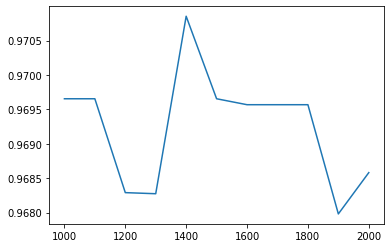

极大值点a： 1400
极大值模型：
KNN:9
SVC:0.7000000000000001
LogisticRegression:0.2
AdaBoost:(500, 0.2)


In [6]:
nameList=[
    "MultinomialNB","DecisionTree",
    "KNN","SVC","LogisticRegression",
    "AdaBoost"] 

plt.plot(range(1000,2050,100),AVEF1)
plt.show()
amax=max(AVEF1)
print("极大值点a：",AVEF1.index(amax)*100+1000)
BestCondition=F1STATUS[AVEF1.index(amax)]
print("极大值模型：")
for i in range(4):  # 4个算法
    print(nameList[2:][i]+':'+str(BestCondition[i][1]))

# plt.bar(nameList, BestCondition) #画最优状况下的各点
# plt.show()



In [7]:
y_train = np.zeros(800)
y_train[640:800] = 1
y_test=np.zeros(200)
y_test[160:200] = 1 
X_train = analyse_characters(train_path)             
X_test = analyse_characters(test_path)

In [8]:
print("————————以下是朴素贝叶斯模型的拟合结果————————")
model1 = MultinomialNB(alpha=1.0e-10) 
model1.fit(X_train,y_train)
result1 = model1.predict(X_test)
print(confusion_matrix(y_test,result1))
print("朴素贝叶斯模型的查准率为：")
print(precision_score(y_test,result1,average='macro'))
print("朴素贝叶斯模型的查全率为：")
print(recall_score(y_test,result1, average='micro'))
print("朴素贝叶斯模型的F1值为：")
print(f1_score(y_test,result1 , average='weighted'))
    
print("————————以下是决策树模型的拟合结果————————")
model2= tree.DecisionTreeClassifier(criterion='entropy')
model2.fit(X_train,y_train)
result2 = model2.predict(X_test)
print(confusion_matrix(y_test,result2))
print("决策树模型的查准率为：")
print(precision_score(y_test,result2,average='macro'))
print("决策树模型的查全率为：")
print(recall_score(y_test,result2, average='micro'))
print("决策树模型的F1值为：")
print(f1_score(y_test,result2 , average='weighted'))

print("————————以下是KNN模型的拟合结果————————")
model3=KNeighborsClassifier(n_neighbors=9,weights='uniform',p=2)
model3.fit(X_train,y_train)
result3=model3.predict(X_test)
print(confusion_matrix(y_test,result3))
print("KNN模型的查准率为：")
print(precision_score(y_test,result3,average='macro'))
print("KNN模型的查全率为：")
print(recall_score(y_test,result3, average='micro'))
print("KNN模型的F1值为：")
print(f1_score(y_test,result3 , average='weighted'))

print("————————以下是SVC模型的拟合结果————————")
model4=SVC(kernel='linear',random_state=1,C=0.7)
model4.fit(X_train,y_train)
result4 = model4.predict(X_test)
print(confusion_matrix(y_test,result4))
print("SVC模型的查准率为：")
print(precision_score(y_test,result4,average='macro'))
print("SVC模型的查全率为：")
print(recall_score(y_test,result4, average='micro'))
print("SVC模型的F1值为：")
print(f1_score(y_test,result4 , average='weighted'))

print("————————以下是逻辑回归模型的拟合结果————————")
model5=LogisticRegression(penalty='l2', C=0.2,solver='lbfgs',tol=0.0001,)
model5.fit(X_train,y_train)
result5 = model5.predict(X_test)
print(confusion_matrix(y_test,result5))
print("逻辑回归模型的查准率为：")
print(precision_score(y_test,result5,average='macro'))
print("逻辑回归模型的查全率为：")
print(recall_score(y_test,result5, average='micro'))
print("逻辑回归模型的F1值为：")
print(f1_score(y_test,result5 , average='weighted'))

print("————————以下是随机森林模型的拟合结果————————")
model6=RandomForestClassifier(n_estimators=200,criterion='entropy')
model6.fit(X_train,y_train)
result6 = model6.predict(X_test)
print(confusion_matrix(y_test,result6))
print("随机森林模型的查准率为：")
print(precision_score(y_test,result6,average='macro'))
print("随机森林模型的查全率为：")
print(recall_score(y_test,result6, average='micro'))
print("随机森林模型的F1值为：")
print(f1_score(y_test,result6 , average='weighted'))

print("————————以下是AdaBoost模型的拟合结果————————")
model7=AdaBoostClassifier(n_estimators=500,learning_rate=0.2)
model7.fit(X_train,y_train)
result7 = model7.predict(X_test)
print(confusion_matrix(y_test,result7))
print("AdaBoost模型的查准率为：")
print(precision_score(y_test,result7,average='macro'))
print("AdaBoost模型的查全率为：")
print(recall_score(y_test,result7, average='micro'))
print("AdaBoost模型的F1值为：")
print(f1_score(y_test,result7 , average='weighted'))

print("————————以下是梯度提升树模型的拟合结果————————")
model8=GradientBoostingClassifier(n_estimators=100,learning_rate=1)
model8.fit(X_train,y_train)
result8 = model8.predict(X_test)
print(confusion_matrix(y_test,result8))
print("梯度提升树模型的查准率为：")
print(precision_score(y_test,result8,average='macro'))
print("梯度提升树模型的查全率为：")
print(recall_score(y_test,result8, average='micro'))
print("梯度提升树模型的F1值为：")
print(f1_score(y_test,result8 , average='weighted'))


————————以下是朴素贝叶斯模型的拟合结果————————
[[158   2]
 [  2  38]]
朴素贝叶斯模型的查准率为：
0.96875
朴素贝叶斯模型的查全率为：
0.98
朴素贝叶斯模型的F1值为：
0.98
————————以下是决策树模型的拟合结果————————
[[148  12]
 [  1  39]]
决策树模型的查准率为：
0.8789972364784839
决策树模型的查全率为：
0.935
决策树模型的F1值为：
0.9377716134997688
————————以下是KNN模型的拟合结果————————
[[156   4]
 [  9  31]]
KNN模型的查准率为：
0.9155844155844155
KNN模型的查全率为：
0.935
KNN模型的F1值为：
0.9333333333333332
————————以下是SVC模型的拟合结果————————
[[158   2]
 [  2  38]]
SVC模型的查准率为：
0.96875
SVC模型的查全率为：
0.98
SVC模型的F1值为：
0.98
————————以下是逻辑回归模型的拟合结果————————
[[159   1]
 [  4  36]]
逻辑回归模型的查准率为：
0.9742165478361797
逻辑回归模型的查全率为：
0.975
逻辑回归模型的F1值为：
0.9746290860841944
————————以下是随机森林模型的拟合结果————————
[[158   2]
 [  3  37]]
随机森林模型的查准率为：
0.965042204172639
随机森林模型的查全率为：
0.975
随机森林模型的F1值为：
0.9748807129618676
————————以下是AdaBoost模型的拟合结果————————
[[155   5]
 [  0  40]]
AdaBoost模型的查准率为：
0.9444444444444444
AdaBoost模型的查全率为：
0.975
AdaBoost模型的F1值为：
0.9755368814192343
————————以下是梯度提升树模型的拟合结果————————
[[157   3]
 [  6  34]]
梯度提升树模型的查准率为：
0.941054551483999

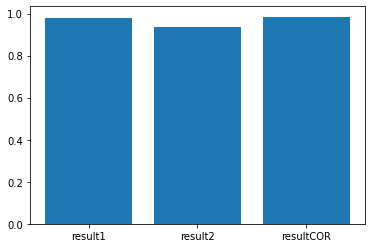

[0.98, 0.9377716134997688, 0.9849284277771205]


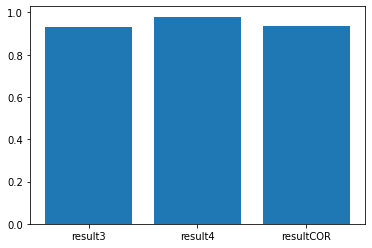

[0.9333333333333332, 0.98, 0.9373983739837399]


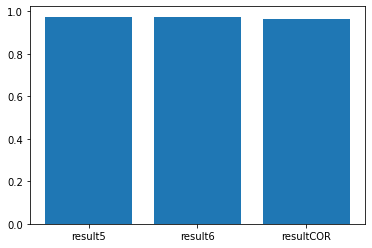

[0.9746290860841944, 0.9748807129618676, 0.9641025641025641]


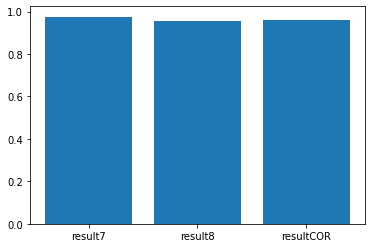

[0.9755368814192343, 0.9543323549515499, 0.9591942820012995]


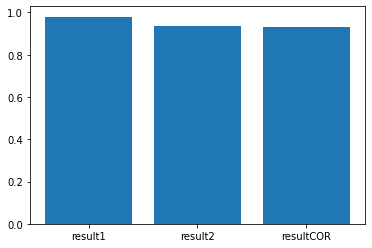

[0.98, 0.9377716134997688, 0.9332015810276679]


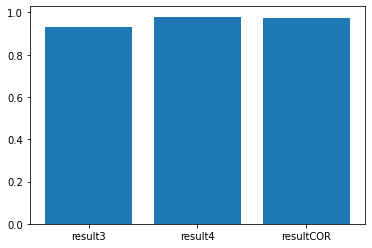

[0.9333333333333332, 0.98, 0.9753335106989474]


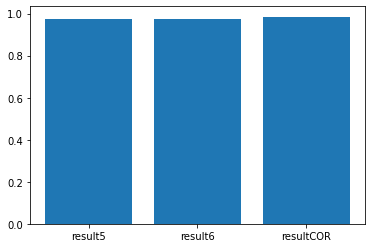

[0.9746290860841944, 0.9748807129618676, 0.9850690816208058]


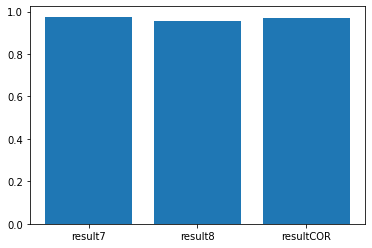

[0.9755368814192343, 0.9543323549515499, 0.9707598874240854]


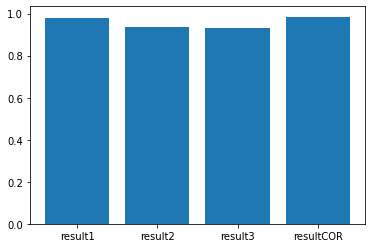

[0.98, 0.9377716134997688, 0.9333333333333332, 0.9850690816208058]


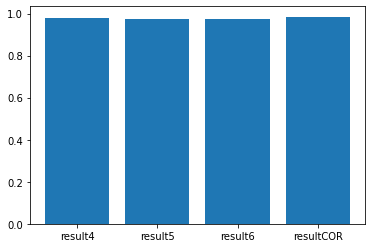

[0.98, 0.9746290860841944, 0.9748807129618676, 0.9849284277771205]


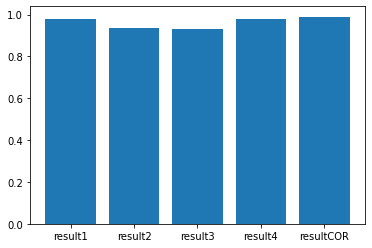

[0.98, 0.9377716134997688, 0.9333333333333332, 0.98, 0.9899028507724159]


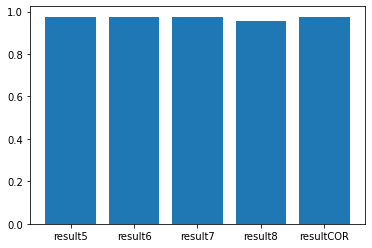

[0.9746290860841944, 0.9748807129618676, 0.9755368814192343, 0.9543323549515499, 0.9748807129618676]


In [9]:
def ANDresult (r1,r2):#两个预测中均判定为垃圾才为垃圾
    newResult=[]
    for i in range(len(r1)):
        newResult.append(r1[i] and r2[i])
    return newResult

def ORresult (r1,r2):#两个预测中有一个判定为垃圾便为垃圾
    newResult=[]
    for i in range(len(r1)):
        newResult.append(r1[i] or r2[i])
    return newResult   

def ADDresult (vr,base): # vr是result列表， base是有1的列表数量
    newResult=[]
    for i in range(len(vr[0])):
        tmp=(reduce(lambda sum,r: sum+r[i], vr,0))
        newResult.append(tmp>=base)
    return newResult

resultList=[ #   八个结果汇聚成列表
    result1,result2,
    result3,result4, 
    result5,result6,
    result7,result8
]
#*************************************利用两个算法协同判断***********************************
resultCOR=ANDresult(result1,result2) # “杂合”的结果
checkList1=[    # 用于打点
f1_score(y_test,result1 , average='weighted'),
f1_score(y_test,result2 , average='weighted'),
f1_score(y_test,resultCOR,average='weighted')
]
plt.bar(["result1","result2","resultCOR"],checkList1)
plt.show()
print(checkList1)

resultCOR=ANDresult(result3,result4) # “杂合”的结果
checkList1=[    # 用于打点
f1_score(y_test,result3 , average='weighted'),
f1_score(y_test,result4 , average='weighted'),
f1_score(y_test,resultCOR,average='weighted')
]
plt.bar(["result3","result4","resultCOR"],checkList1)
plt.show()
print(checkList1)

resultCOR=ANDresult(result5,result6) # “杂合”的结果
checkList1=[    # 用于打点
f1_score(y_test,result5 , average='weighted'),
f1_score(y_test,result6 , average='weighted'),
f1_score(y_test,resultCOR,average='weighted')
]
plt.bar(["result5","result6","resultCOR"],checkList1)
plt.show()
print(checkList1)

resultCOR=ANDresult(result7,result8) # “杂合”的结果
checkList1=[    # 用于打点
f1_score(y_test,result7 , average='weighted'),
f1_score(y_test,result8 , average='weighted'),
f1_score(y_test,resultCOR,average='weighted')
]
plt.bar(["result7","result8","resultCOR"],checkList1)
plt.show()
print(checkList1)
#*************************************利用两个算法协同判断***********************************
resultCOR=ORresult(result1,result2) # “杂合”的结果
checkList1=[    # 用于打点
f1_score(y_test,result1 , average='weighted'),
f1_score(y_test,result2 , average='weighted'),
f1_score(y_test,resultCOR,average='weighted')
]
plt.bar(["result1","result2","resultCOR"],checkList1)
plt.show()
print(checkList1)

resultCOR=ORresult(result3,result4) # “杂合”的结果
checkList1=[    # 用于打点
f1_score(y_test,result3 , average='weighted'),
f1_score(y_test,result4 , average='weighted'),
f1_score(y_test,resultCOR,average='weighted')
]
plt.bar(["result3","result4","resultCOR"],checkList1)
plt.show()
print(checkList1)

resultCOR=ORresult(result5,result6) # “杂合”的结果
checkList1=[    # 用于打点
f1_score(y_test,result5 , average='weighted'),
f1_score(y_test,result6 , average='weighted'),
f1_score(y_test,resultCOR,average='weighted')
]
plt.bar(["result5","result6","resultCOR"],checkList1)
plt.show()
print(checkList1)

resultCOR=ORresult(result7,result8) # “杂合”的结果
checkList1=[    # 用于打点
f1_score(y_test,result7 , average='weighted'),
f1_score(y_test,result8 , average='weighted'),
f1_score(y_test,resultCOR,average='weighted')
]
plt.bar(["result7","result8","resultCOR"],checkList1)
plt.show()
print(checkList1)
#*************************************利用三个算法协同判断***********************************
checkList2=list(map(lambda r : f1_score(y_test,r,average='weighted'),resultList[:3]))
checkList2+=[
f1_score(y_test,ADDresult(resultList[:3],2),average='weighted') #取前3个结果，要求至少2个为1
]
plt.bar(["result1","result2","result3","resultCOR"],checkList2)
plt.show()
print(checkList2)

checkList2=list(map(lambda r : f1_score(y_test,r,average='weighted'),resultList[3:6]))
checkList2+=[
f1_score(y_test,ADDresult(resultList[3:6],2),average='weighted') #取前3个结果，要求至少2个为1
]
plt.bar(["result4","result5","result6","resultCOR"],checkList2)
plt.show()
print(checkList2)
#*************************************利用四个算法协同判断***********************************
checkList2=list(map(lambda r : f1_score(y_test,r,average='weighted'),resultList[:4]))
checkList2+=[
f1_score(y_test,ADDresult(resultList[:4],3),average='weighted') #取前4个结果，要求至少3个为1
]
plt.bar(["result1","result2","result3","result4","resultCOR"],checkList2)
plt.show()
print(checkList2)

checkList2=list(map(lambda r : f1_score(y_test,r,average='weighted'),resultList[4:]))
checkList2+=[
f1_score(y_test,ADDresult(resultList[4:],3),average='weighted') #取后4个结果，要求至少3个为1
]
plt.bar(["result5","result6","result7","result8","resultCOR"],checkList2)
plt.show()
print(checkList2)

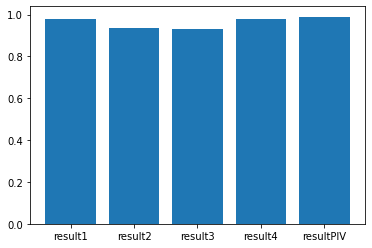

0.1000	0.7000	0.0500	0.1500	最优f1值: 0.99


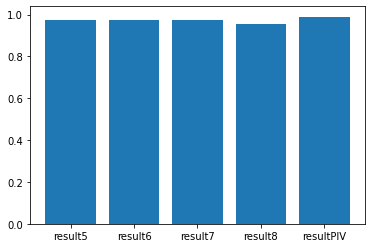

0.1000	0.1500	0.7000	0.0500	最优f1值: 0.99


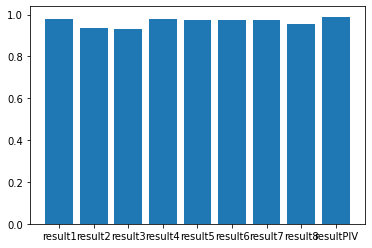

0.1500	0.1500	0.0500	0.0500	0.0500	0.0500	0.4500	0.0500	最优f1值: 0.99


In [10]:
#*************************************利用四个算法协同判断,并求得最优参数***********************************
def combine4Result(vecResult,pivot):
    maxF1=-1
    maxStatus=None
    for i in np.arange(0.05,0.85,0.05):
        for j in np.arange(0.05,0.85,0.05):
            for k in np.arange(0.05,0.85,0.05):
                for l in np.arange(0.05,0.85,0.05):
                    if i+j+k+l==1:
                        weightedResult=[
                            vecResult[0]*i,vecResult[1]*j,
                            vecResult[2]*k,vecResult[3]*l
                        ]
                        sumResult=reduce(lambda sumr,r:sumr+r,weightedResult)
                        ansResult=list(map(lambda x: 1 if x>=pivot else 0,sumResult))
                        f1=f1_score(y_test,ansResult,average='weighted') 
                        if f1>maxF1:
                            maxF1=f1
                            maxStatus=[i,j,k,l]
    return (maxF1,maxStatus)
#*************************************利用八个算法协同判断,并求得最优参数***********************************
def combine8Result(vecResult,pivot):
    maxF1=-1
    maxStatus=None
    for i in np.arange(0.05,0.65,0.1):
        for j in np.arange(0.05,0.65,0.1):
            for k in np.arange(0.05,0.65,0.1):
                for l in np.arange(0.05,0.65,0.1):
                    for a in np.arange(0.05,0.65,0.1):
                        for b in np.arange(0.05,0.65,0.1):
                            for c in np.arange(0.05,0.65,0.1):
                                for d in np.arange(0.05,0.65,0.1):
                                    if i+j+k+l+a+b+c+d==1:
                                        weightedResult=[
                                            vecResult[0]*i,vecResult[1]*j,
                                            vecResult[2]*k,vecResult[3]*l,
                                            vecResult[4]*a,vecResult[5]*b,
                                            vecResult[6]*c,vecResult[7]*d
                                        ]
                                        sumResult=reduce(lambda sumr,r:sumr+r,weightedResult)
                                        ansResult=list(map(lambda x: 1 if x>=pivot else 0,sumResult))
                                        f1=f1_score(y_test,ansResult,average='weighted') 
                                        if f1>maxF1:
                                            maxF1=f1
                                            maxStatus=[i,j,k,l,a,b,c,d]
    return (maxF1,maxStatus)
#*************************************利用四个算法协同判断,并求得最优参数***********************************
c4=combine4Result(resultList[:4],0.8)
checkList3=list(map(lambda r : f1_score(y_test,r,average='weighted'),resultList[:4]))+[c4[0]]
plt.bar(["result1","result2","result3","result4","resultPIV"],checkList3)
plt.show()
for i in range(len(checkList3)-1):
    print("%.4f"%c4[1][i],end='\t')
print("最优f1值:",c4[0])

c5=combine4Result(resultList[4:],0.8)
checkList3=list(map(lambda r : f1_score(y_test,r,average='weighted'),resultList[4:]))+[c5[0]]
plt.bar(["result5","result6","result7","result8","resultPIV"],checkList3)
plt.show()
for i in range(len(checkList3)-1):
    print("%.4f"%c5[1][i],end='\t')
print("最优f1值:",c5[0])
#*************************************利用八个算法协同判断,并求得最优参数***********************************
c8=combine8Result(resultList,0.8)
checkList4=list(map(lambda r : f1_score(y_test,r,average='weighted'),resultList))+[c4[0]]
plt.bar(["result1","result2","result3","result4","result5","result6","result7","result8","resultPIV"],checkList4)
plt.show()
for i in range(len(checkList4)-1):
    print("%.4f"%c8[1][i],end='\t')
print("最优f1值:",c8[0])